# **Synthetic Dental X-Ray Generation and Segmentation Analysis**

## Imports

Imports

In [42]:
import os, glob, time, random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

import warnings
warnings.filterwarnings("ignore")

Environment report

In [43]:
print("Environment")
print("-----------")
print(f"Python        : {sys.version.split()[0]}")
print(f"NumPy         : {np.__version__}")
print(f"PyTorch       : {torch.__version__}")
print(f"OpenCV        : {cv2.__version__}")
print()

# CUDA / device check
if torch.cuda.is_available():
    print("CUDA available")
    print(f"GPU           : {torch.cuda.get_device_name(0)}")
    print(f"CUDA version  : {torch.version.cuda}")
    print(f"cuDNN         : {torch.backends.cudnn.version()}")
else:
    print("CUDA NOT available (training will be slow)")

Environment
-----------
Python        : 3.10.11
NumPy         : 2.2.6
PyTorch       : 2.8.0+cu128
OpenCV        : 4.12.0

CUDA available
GPU           : NVIDIA GeForce RTX 2060
CUDA version  : 12.8
cuDNN         : 91002


## Globals

In [44]:
SEED = 13
PROJECT_ROOT = Path("../workspace")
DATA_ROOT_IMG = PROJECT_ROOT / "teeth_seg_dataset/d2/img"
MASK_DIR = PROJECT_ROOT / "teeth_seg_dataset/d2/masks_machine"
IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 2
CHANNELS = 1
EPOCHS = 10
LR = 2e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utils

In [45]:
def set_seed(seed: int=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [46]:
def pad_to_square(img, fill=0):
    w, h = img.size
    if w == h: return img
    s = max(w, h)
    out = Image.new(img.mode, (s, s), color=fill)
    out.paste(img, ((s - w) // 2, (s - h) // 2))
    return out

In [47]:
def to_tensor_gray(img):
    if img.mode != "L": img = img.convert("L")
    arr = np.array(img, dtype=np.float32) / 255.0   # (H, W)
    arr = arr[None, ...]    # (1, H, W)
    return torch.from_numpy(arr)

In [48]:
def denorm(x):
    # [-1, 1] -> [0, 1]
    return (x.clamp(-1, 1) + 1) * 0.5

In [49]:
def show_grid(t, nrow=8, title=None):
    g = make_grid(denorm(t.detach().cpu()), nrow=nrow, padding=2)
    g_np = g.squeeze(0).permute(1, 2, 0).numpy()
    plt.figure(figsize=(22, 16), dpi=160)
    plt.axis("off")
    if title: plt.title(title)
    plt.imshow(g_np.squeeze(), cmap="gray")
    plt.show()

## Data

In [50]:
def list_image_files(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.jpg"), recursive=True))

class DentalXRays(Dataset):
    def __init__(self, root, size=256):
        super().__init__()
        self.paths = list_image_files(root)
        self.size = size
        if not self.paths:
            print(f"[WARNING] No .jpg images found under: {root}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("L")
        img = pad_to_square(img, fill=0)
        img = img.resize((self.size, self.size), resample=Image.BICUBIC)
        t = to_tensor_gray(img) # [0, 1]
        t = t * 2.0 - 1.0   # [-1, 1] for GAN
        return t

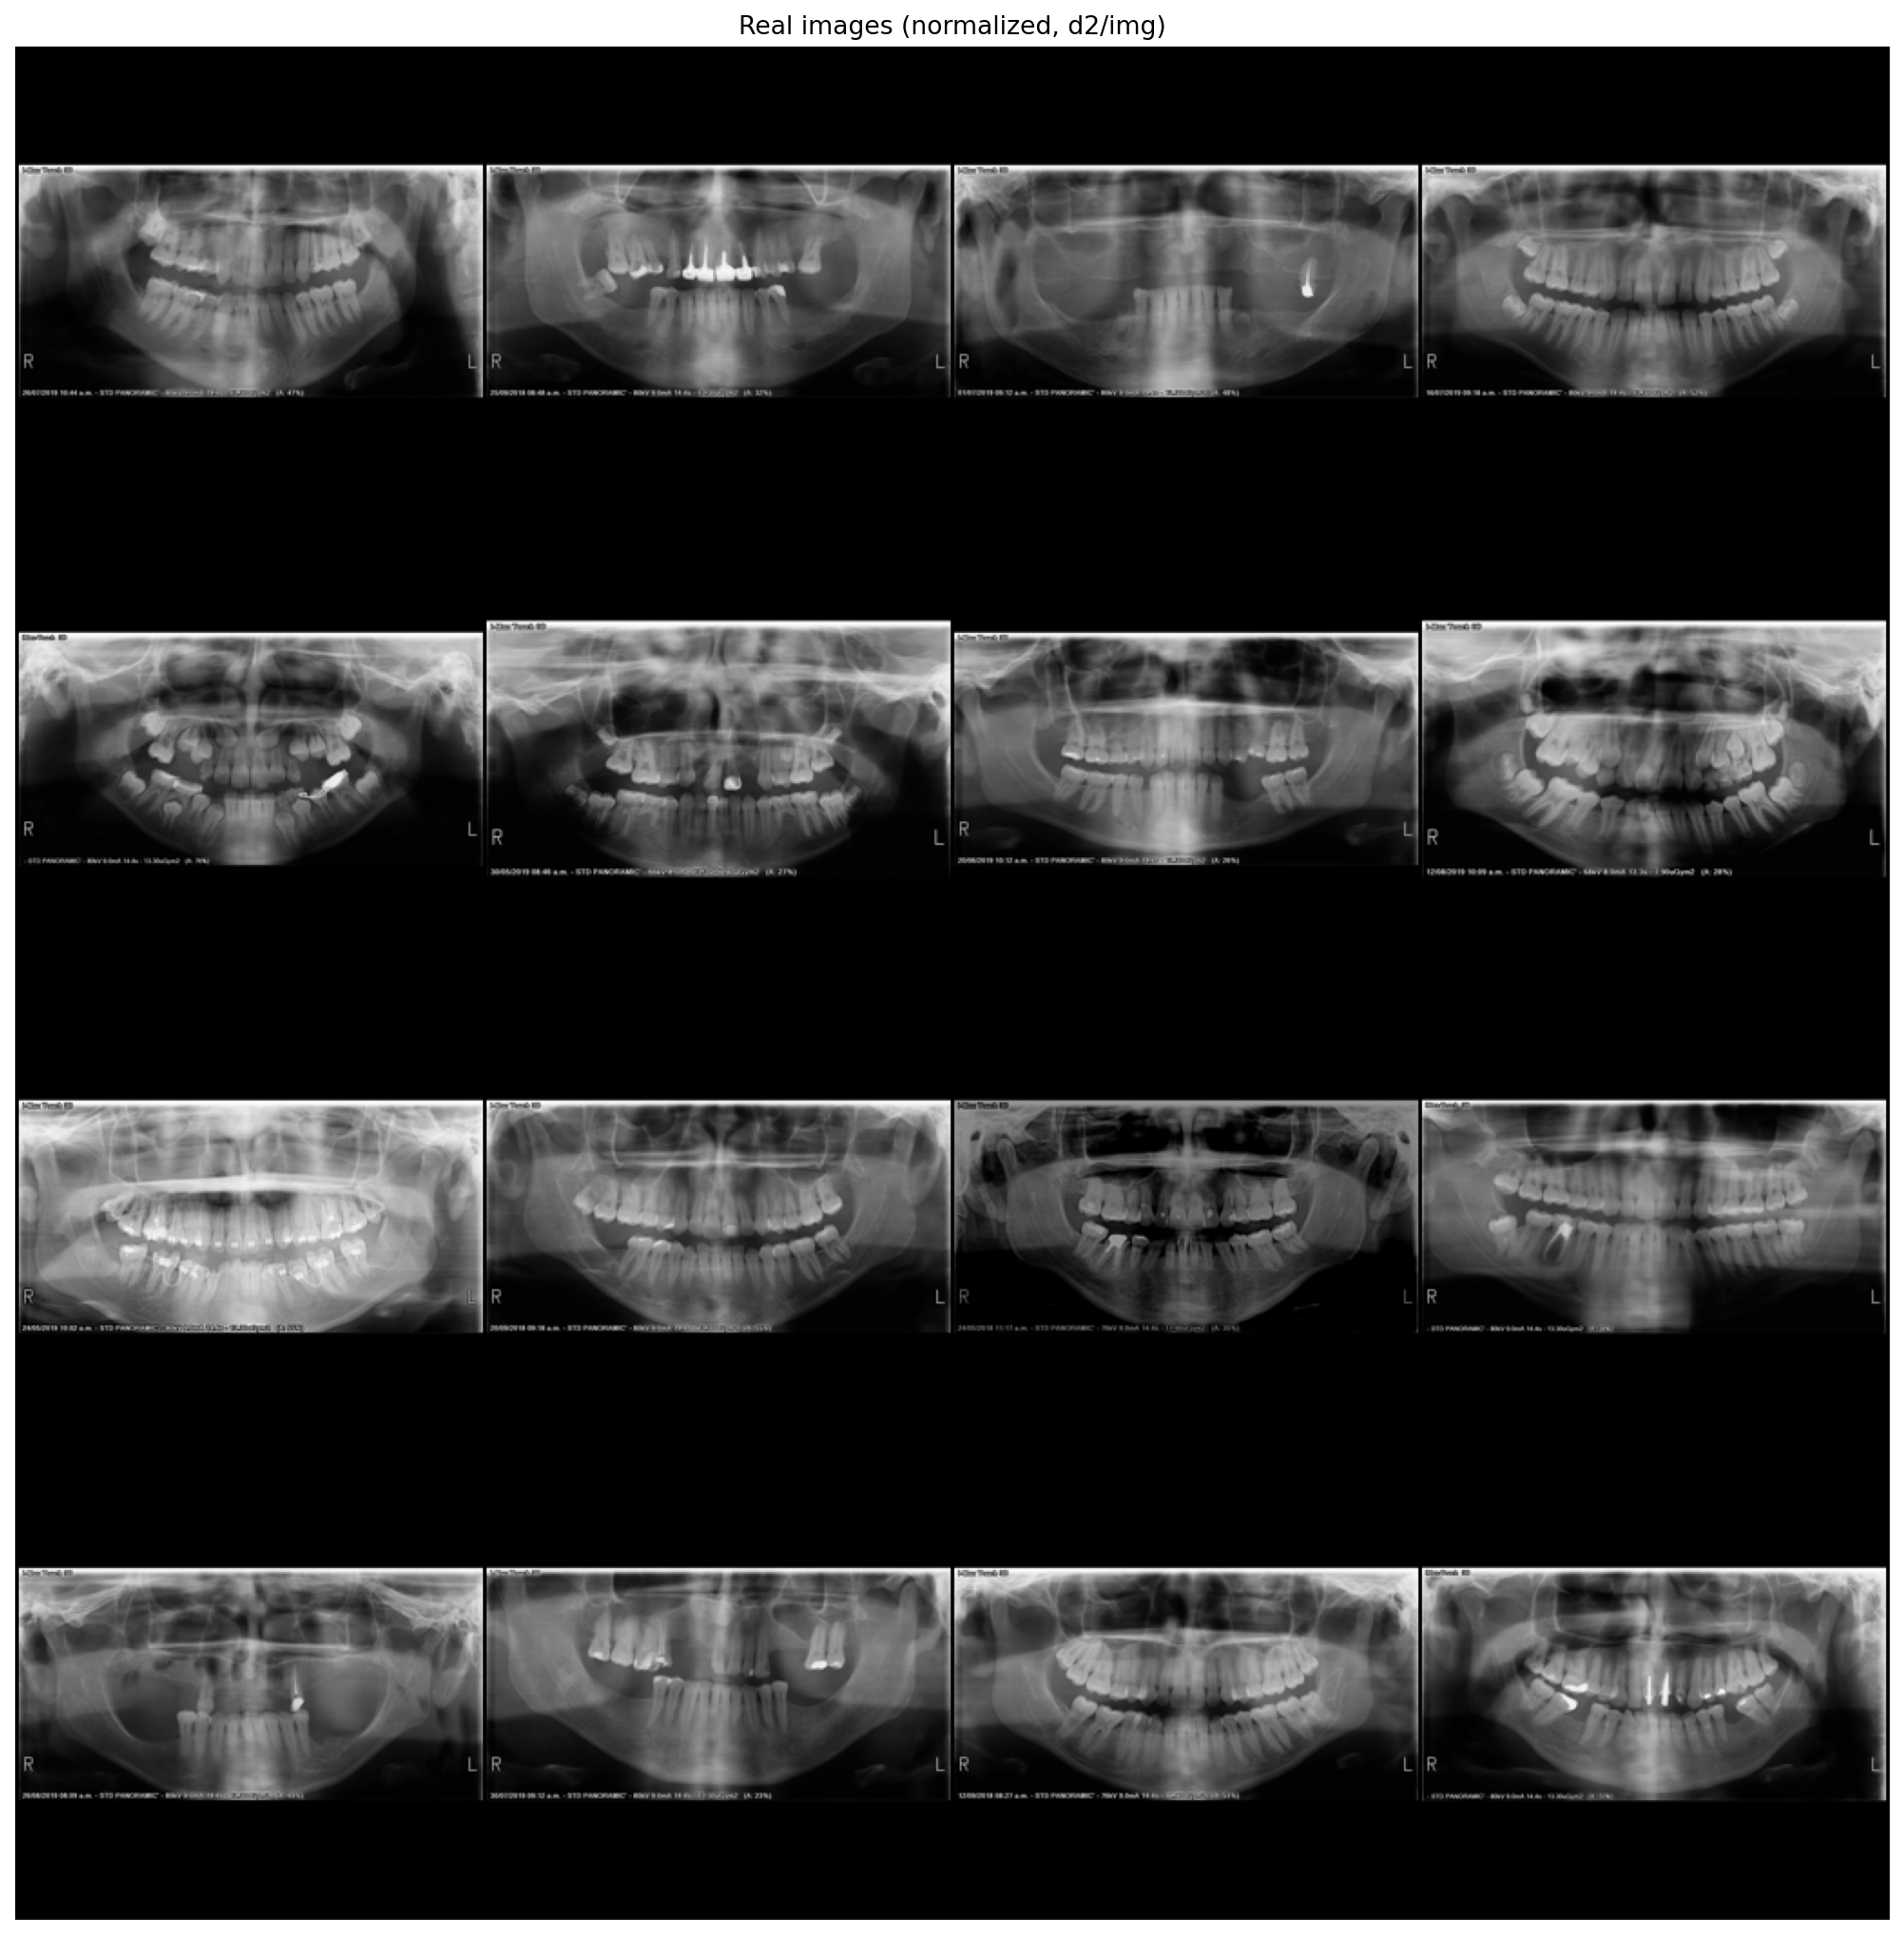

Loaded 598 .jpg images from ../workspace/teeth_seg_dataset/d2/img


In [51]:
dataset = DentalXRays(DATA_ROOT_IMG, IMG_SIZE)
if len(dataset) == 0:
    raise RuntimeError(f"No .jpg images in {DATA_ROOT_IMG}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

# Quick visual sanity check
batch = next(iter(loader))
show_grid(batch[:16], nrow=4, title="Real images (normalized, d2/img)")
print(f"Loaded {len(dataset)} .jpg images from {DATA_ROOT_IMG}")

## Network

## Train

## Evaluation